# Problem Set 4, due March 16 at 11:59pm

### Before You Start


This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.

* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions (especially the sections on vectorized computation and computational efficiency).

* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 

* Part 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last. This can help you increase your scores

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names).

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import random
%matplotlib inline   
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
import statsmodels.formula.api as smf


---

## Part 1: Getting oriented


### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. 

(a) Regress the housing price on the number of rooms per house. Draw a scatter plot of housing price (y-axis) against rooms (x-axis), and draw the regression line in blue. You might want to make the dots semi-transparent if it improves the presentation of the figure.

(b) Regress the housing price on the number of rooms per house and the (number of rooms per house) squared. Show the (curved) regression line in green.

(c) Interpret your results.

In [2]:
# Load data 
bdata = load_boston()
df = pd.read_csv('data.txt', sep=" ", header=None) 
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT']
target = pd.read_csv('MEDV.txt', sep=" ", header=None) 
df.insert(13, "MEDV", target, True) 

In [3]:
# Linear regression
regr_1 = LinearRegression()
regr_1.fit(df[['RM']], df['MEDV'])
r_1 = regr_1.score(df[['RM']], df['MEDV'])

print('First regression')
print('Coefficient: {:.2f}'.format(regr_1.coef_[0]))
print('Intercept: {:.2f}'.format(regr_1.intercept_))
print('R squared: {:.2f}'.format(r_1))

First regression
Coefficient: 8.96
Intercept: -35.58
R squared: 0.47


In [4]:
# Regression on linear term and quadratic term
df_2 = df.copy()
df_2 = df_2.sort_values(by = ['RM'],ascending = True)
df_2['RM_square'] = df_2['RM'] ** 2

regr_2 = LinearRegression()
regr_2.fit(df_2[['RM', 'RM_square']], df_2['MEDV'])
r_2 = regr_2.score(df_2[['RM', 'RM_square']], df_2['MEDV'])
print('\nSecond regression')
print('Coefficient of RM: {:.2f}'.format(regr_2.coef_[0]))
print('Coefficient of RM square: {:.2f}'.format(regr_2.coef_[1]))
print('Intercept: {:.2f}'.format(regr_2.intercept_))
print('R squared: {:.2f}'.format(r_2))


Second regression
Coefficient of RM: -23.79
Coefficient of RM square: 2.47
Intercept: 71.74
R squared: 0.54


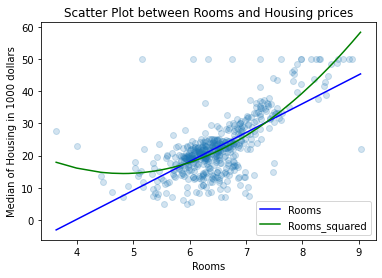

In [5]:
# Plot of linear and quadratic regression lines
plt.scatter(df_2['RM'],df_2['MEDV'],marker='o',alpha = 0.2)
plt.title("Scatter Plot between Rooms and Housing prices")
plt.xlabel("Rooms")
plt.ylabel("Median of Housing in 1000 dollars")
slope1,intercept1 = np.polyfit(df_2['RM'],df_2['MEDV'],1)
slope2,intercept2 = np.polyfit(df_2['RM_square'],df_2['MEDV'],1)
y = regr_2.coef_[1] * df_2['RM_square'] + regr_2.coef_[0] * df_2['RM'] + regr_2.intercept_
plt.plot(df_2['RM'], slope1 * df_2['RM'] + intercept1, color='blue',label = 'Rooms')
plt.plot(df_2['RM'], y , color='green' , label = 'Rooms_squared')
plt.legend()

#### Observations

- *In the bivariate linear regression, we estimate that the median housing price will increase by roughly \$9000 for each additional room in the house.*

- *Using the second model, including a quadratic term and a linear term, we observe a quadratic relationship between median housing price and number of rooms.  The positive quadratic term and negative linear term indicate convex curvature, i.e. housing price increases more steeply for houses with a greater number of rooms.*

- *The r squared increases with the addition of the quadratic term. This could reflect that the quadratic term is a more appropriate fit for the data; however, it's also the case that r2 will always increase (on the training set) with an increase in the number and complexity of predictor variables.*

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 5-fold cross-validation to fit the regression model (a) from 1.1, i.e. the linear fit of housing price on number of rooms per house. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Create a new scatterplot of housing price against rooms, and draw the five different regression lines in light blue, and the oroginal regression line from 1.1 in red (which was estimated using the full dataset). What do you notice?

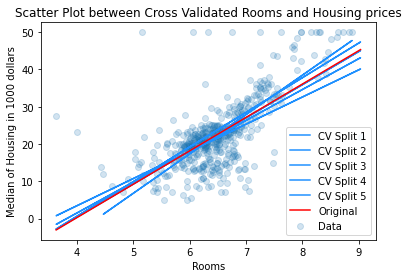

In [6]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
slope = []
intercept = []
counter = 1
for train_index, test_index in kf.split(df):
    regr = LinearRegression()
    df_train = df.iloc[train_index]
    regr.fit(df_train[['RM']], df_train['MEDV'])
    slope.append(regr.coef_[0])
    plt.plot(df_train['RM'], df_train['RM']* regr.coef_[0] + regr.intercept_, color='dodgerblue',
             label = 'CV Split %i' % counter)
    counter += 1
plt.title("Scatter Plot between Cross Validated Rooms and Housing prices")
plt.xlabel("Rooms")
plt.ylabel("Median of Housing in 1000 dollars")
plt.scatter(df_2['RM'],df_2['MEDV'],marker='o',alpha = 0.2,label = 'Data')
plt.plot(df_2['RM'], regr_1.coef_[0]*df_2['RM'] + regr_1.intercept_, color='red',label = 'Original')
plt.legend()
plt.show()


#### Observations 

*Each of the linear regressions estimated on one of the cross-validation splits is very similar to the overall regression line (though not exactly the same). It appears that the variance in both slopes and intercepts is quite small.*

## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds
* How do your coefficients compare to the ones estimated through standard libraries? Does this depend on *R*?

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* Hint 2: Some people like to include a MaxIterations parameter in their gradient descent algorithm, to prevent divergence. 

In [7]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    co-efficient
"""
def bivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    alpha = 0.0
    beta = 0.0
    n = len(xvalues)
    cost = np.inf
    epsilon = 1e-6
    xvaluest = np.array(xvalues)
    yvaluest = np.array(yvalues)
    for i in range(MaxIterations):
        alpha_old = alpha
        beta_old = beta
        cost_old = cost
        alpha -= R / n * ((alpha + beta * xvaluest - yvaluest).sum())
        beta -= R / n * (((alpha_old + beta * xvaluest - yvaluest) * xvaluest).sum())
        cost = 1.0 / (2 * n) * (((alpha + beta * xvaluest - yvaluest) ** 2).sum())
        # Use this code block to implement stopping condition based on cost
        #if cost_old - cost < 0:
            #print('not converge stopped after iteration times: {}'.format(i))
            #break
        # Use this code block to implement stopping condition based on parameters learned
        if abs(alpha - alpha_old) < epsilon and abs(beta - beta_old) < epsilon:
            print('cost < 0.0001 stopped after iteration times: {}'.format(i))
            break
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta


print("OLS  model parameters\n intercept: {:.2f}, coefficient: {:.2f}".format(regr_1.intercept_, regr_1.coef_[0]))

print('\nExperiment 1: R=0.001')
print(bivariate_ols(df['RM'], df['MEDV'], 0.001, 1000000))

print('\nExperiment 2: R=0.01')
print(bivariate_ols(df['RM'], df['MEDV'], 0.01, 100000))

print('\nExperiment 3: R=0.1')
print(bivariate_ols(df['RM'], df['MEDV'], 0.1, 1000000))

OLS  model parameters
 intercept: -35.58, coefficient: 8.96

Experiment 1: R=0.001
cost < 0.0001 stopped after iteration times: 527252
Time taken: 22.94 seconds
(-35.48865117951902, 8.946581040638165)

Experiment 2: R=0.01
cost < 0.0001 stopped after iteration times: 72883
Time taken: 3.27 seconds
(-35.56745311896449, 8.95859287158155)

Experiment 3: R=0.1


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-7-5d9a52bce482>:45: RuntimeWarning: overflow encountered in square
  cost = 1.0 / (2 * n) * (((alpha + beta * xvaluest - yvaluest) ** 2).sum())
<ipython-input-7-5d9a52bce482>:44: RuntimeWarning: invalid value encountered in double_scalars
  beta -= R / n * (((alpha_old + beta * xvaluest - yvaluest) * xvaluest).sum())


Time taken: 41.19 seconds
(nan, nan)


#### Observations

*Gradient descent failed to converge with a learning rate of 0.1. However, with smaller learning rates (0.01 or 0.001), gradient descent converged to parameter values very similar to the coefficients computed via the OLS packages. Smaller learning rates require more iterations and thus take longer to complete.*

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [8]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using TAX and RM as independent variables. Standardize these variables before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem

In [9]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)[:, np.newaxis]
    n, variable_n = xvalue_matrix.shape 
    alpha = 0.0
    beta_array = np.transpose(np.array([[0.0] * variable_n]))
    cost = np.inf
    epsilon = 0.00001
    for i in range(MaxIterations):
        cost_old = cost
        alpha_old = alpha
        beta_array_old = np.copy(beta_array)
        part_1 = alpha_old + np.dot(xvalue_matrix, beta_array_old) - yvalues
        alpha -= R / n * (part_1.sum())
        beta_array -= R / n * (np.dot(xvalue_matrix.T, part_1))
        part_2 = alpha + np.dot(xvalue_matrix, beta_array) - yvalues
        cost = 1.0 / (2 * n) * ((part_2 ** 2).sum())
        # Use this code block to implement stopping based on cost
        #if cost_old - cost < 0:
        #    print('not converge stopped after iteration times: {}'.format(i))
        #    break
        # Use this code block to implement stopping based on parameters learned
        if abs(alpha-alpha_old) < epsilon and max(abs(beta_array-beta_array_old)) < epsilon:
            print('cost < 0.00001 stopped after iteration times: {}'.format(i))
            break
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta_array

In [10]:
# Regress on RM and TAX using our gradient descent algorithm
df_cp = df.copy()
df_norm = standardize(df_cp)
df_norm['MEDV'] = df['MEDV']

print('\nExperiment 1: R=0.001')
print(multivariate_ols(df_norm[['RM', 'TAX']], df_norm['MEDV'], 0.001, 100000))

print('\nExpeirment 2: R=0.01')
print(multivariate_ols(df_norm[['RM', 'TAX']], df_norm['MEDV'], 0.01, 100000))

print('\mExperiment 3: R=0.1')
print(multivariate_ols(df_norm[['RM', 'TAX']], df_norm['MEDV'], 0.1, 2000000))


Experiment 1: R=0.001
cost < 0.00001 stopped after iteration times: 7717
Time taken: 0.34 seconds
(22.52282350016782, array([[ 5.53282762],
       [-2.72687205]]))

Expeirment 2: R=0.01
cost < 0.00001 stopped after iteration times: 998
Time taken: 0.04 seconds
(22.531823728800912, array([[ 5.53762751],
       [-2.72245174]]))
\mExperiment 3: R=0.1
cost < 0.00001 stopped after iteration times: 125
Time taken: 0.01 seconds
(22.532767654350998, array([[ 5.53861529],
       [-2.7214836 ]]))


In [11]:
# Regress on RM and TAX using sklearn's built-in algorithm, for comparison
regr_3 = LinearRegression()
regr_3.fit(df_norm[['RM', 'TAX']], df_norm['MEDV'])
print('Intercept: {:.2f}'.format(regr_3.intercept_))
print('Coefficient of RM: {:.2f}'.format(regr_3.coef_[0]))
print('Coefficient of TAX: {:.2f}'.format(regr_3.coef_[1]))

Intercept: 22.53
Coefficient of RM: 5.54
Coefficient of TAX: -2.72


#### Observations
*Again, we observe that higher learning rates converge much faster than smaller ones (e.g. 125 iterations to convergence for R=0.1, vs. 7,717 for R=0.001). It looks like for this problem all three learning rates converged successfully, in that the parameters are similar to those obtained by scikit-learn's OLS functionality. Interestingly, our algorithm is faster (for all learning rates) than the algorithm scikit-learn seems to be using to find the closed form solution.*

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [12]:
# Regress on RM and TAX using sklearn's built-in algorithm, for comparison
print('Experiment 1: R=0.1')
print(multivariate_ols(df[['RM', 'TAX']], df['MEDV'], 0.1, int(1e6)))

print('\nExperiment 2: R=0.01')
print(multivariate_ols(df[['RM', 'TAX']], df['MEDV'], 0.01, int(1e6)))

print('\nExperiment 3: R=0.001')
print(multivariate_ols(df[['RM', 'TAX']], df['MEDV'], 0.001, int(1e6)))

Experiment 1: R=0.1


<ipython-input-9-22511a49be46>:46: RuntimeWarning: overflow encountered in square
  cost = 1.0 / (2 * n) * ((part_2 ** 2).sum())
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-9-22511a49be46>:43: RuntimeWarning: invalid value encountered in double_scalars
  alpha -= R / n * (part_1.sum())
<ipython-input-9-22511a49be46>:44: RuntimeWarning: invalid value encountered in subtract
  beta_array -= R / n * (np.dot(xvalue_matrix.T, part_1))


Time taken: 45.18 seconds
(nan, array([[nan],
       [nan]]))

Experiment 2: R=0.01
Time taken: 53.37 seconds
(nan, array([[nan],
       [nan]]))

Experiment 3: R=0.001
Time taken: 47.02 seconds
(nan, array([[nan],
       [nan]]))


In [13]:
# Regress on RM and TAX using sklearn's built-in algorithm, for comparison
regr_4 = LinearRegression()
regr_4.fit(df[['RM', 'TAX']], df['MEDV'])
print('Intercept: {:.3f}'.format(regr_4.intercept_))
print('Coefficient of RM: {:.3f}'.format(regr_4.coef_[0]))
print('Coefficient of TAX: {:.3f}'.format(regr_4.coef_[1]))

Intercept: -21.695
Coefficient of RM: 7.854
Coefficient of TAX: -0.016


#### Observations

*When we do not standardize our features, our algorithm does not always converge, or it takes a very long time to do so. However, for an appropriate learning rate, it may be possible to achieve convergence, but none of the learning rates tried here successfully converge.*

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Make sure to first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that. Use 5-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for TAX and RM). Since there are 5 folds, there will be 5 sets of three coefficients -- report them all in a 5x3 table.

In [14]:
def compute_rmse(predictions, yvalues):
    P = np.array(predictions)
    Y = np.array(yvalues)
    rmse = ((P-Y)**2).sum()*1.0 / len(P) 
    rmse = np.sqrt(rmse)
    return rmse

In [15]:
kf = KFold(n_splits=5)
slope = []
r_all = []
rmse_all = []
for train_index, test_index in kf.split(df):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]
    df_train_norm = standardize(df_train)
    df_train_norm['MEDV'] = df_train['MEDV']
    df_test_norm = standardize(df_test)
    df_test_norm['MEDV'] = df_test['MEDV']
    
    alpha, beta_array = multivariate_ols(df_train_norm[['RM', 'TAX']], df_train_norm['MEDV'], 0.001, 100000)
    r_all.append([alpha, beta_array[0][0], beta_array[1][0]])
    
    predict = alpha + beta_array[0][0] * df_test_norm['RM'] + beta_array[1][0] * df_test_norm['TAX']
    rmse_this = compute_rmse(predict, df_test_norm['MEDV'])
    rmse_all.append(rmse_this)

cost < 0.00001 stopped after iteration times: 7718
Time taken: 0.31 seconds
cost < 0.00001 stopped after iteration times: 7696
Time taken: 0.54 seconds
cost < 0.00001 stopped after iteration times: 7634
Time taken: 0.37 seconds
cost < 0.00001 stopped after iteration times: 7744
Time taken: 0.32 seconds
cost < 0.00001 stopped after iteration times: 7786
Time taken: 0.35 seconds


Matrix Co-efficient table 5 * 3

In [16]:
results = pd.DataFrame(r_all)
results.columns = ['Intercept', 'RM', 'TAX']
results.index = ['CV Split %i' % i for i in range(1, 6)]
results

,Intercept,RM,TAX
CV Split 1,22.556102,5.577465,-3.277019
CV Split 2,22.051747,4.880977,-2.955826
CV Split 3,20.734211,4.119582,-2.576018
CV Split 4,23.145077,6.386877,-3.077561
CV Split 5,24.127057,6.479491,-1.211879


#### Observations

*As with problems 1.1 and 1.2, we see that the distribution of parameter estimates from k-fold cross-validation are close to the parameters estimated without carefully separating our training and testing datasets. Small deviations are expected, as the parameters are being fit on a subset of the original data.*

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the cross-validated RMSE for each of the 5 folds above. In other words, in fold 1, use the parameters estimated on the 80% of the data to make predictions for the 20%, and calculate the RMSE for those 20%. Repeate this for the remaining folds. Report the RMSE for each of the 5-folds, and the average (mean) RMSE across the five folds. How does this average RMSE compare to the performance of your nearest neighbor algorithm from the last problem set?

In [17]:
#Printing RMSE for each fold
print(pd.Series(rmse_all,index = [1,2,3,4,5]))

#Printing RMSE for average
print('Mean RMSE: {:.2f}'.format(np.mean(rmse_all)))

1     4.325922
2     5.897736
3    10.228694
4    10.419837
5    10.766660
dtype: float64
Mean RMSE: 8.33


*The exact RMSE will depend on the randomized split, as well as the parameters used for kNN. In any case the RMSE should be close to RMSE of that obtained through KNN.*

### Extra Credit 1: Logistic Regression

For extra credit, implement logistic regression using gradient descent. Create a new variable (EXPENSIVE) to indicate whether the median housing price is more than $40,000. Use your model  a logistic regression of EXPENSIVE on CHAS and RM. Report your results.

In [18]:
df_norm['EXPENSIVE'] = df_norm.apply(lambda x: 1 if x['MEDV']>40 else 0, axis=1)

def multivariate_lg(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)[:, np.newaxis]
    n, variable_n = xvalue_matrix.shape # sample number, varaibels number
    alpha = 0.0
    beta_array = np.transpose(np.array([[0.0] * variable_n]))
    cost = np.inf
    epsilon = 0.0001
    for i in range(MaxIterations):
        cost_old = cost
        alpha_old = alpha
        beta_array_old = np.copy(beta_array)
        part_1 = 1.0 /(1 + np.exp(-(alpha_old + np.dot(xvalue_matrix, beta_array_old)))) - yvalues
        alpha -= R / n * (part_1.sum())
        beta_array -= R / n * (np.dot(np.transpose(xvalue_matrix), part_1))
        part_2 = 1.0 /(1 + np.exp(-(alpha + np.dot(xvalue_matrix, beta_array)))) - yvalues
        y_predict = 1.0 /(1 + np.exp(-(alpha + np.dot(xvalue_matrix, beta_array))))
        cost = np.sum(- yvalues * np.log(y_predict) - (1 - yvalues) * np.log(1 - y_predict))
        if cost_old - cost < 0:
            print('not converge stopped after iteration times: {}'.format(i))
            break
        if abs(alpha-alpha_old) < epsilon and max(abs(beta_array-beta_array_old)) < epsilon:
            print('cost < 0.00001 stopped after iteration times: {}'.format(i))
            break
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta_array

multivariate_lg(df_norm[['CHAS','RM']], df_norm['EXPENSIVE'], 0.1, 100000)

cost < 0.00001 stopped after iteration times: 2969
Time taken: 0.46 seconds


(-4.374887391488019,
 array([[0.3115166 ],
        [2.03463571]]))

In [19]:
def f_log(x):
    denom=(1.0+ np.exp(-(alpha+beta_array[0][0]*x[:,0]+beta_array[1][0]*x[:,1])))
    return 1.0/denom

In [20]:
n = len(df)
rand_order = np.arange(0, n)
np.random.shuffle(rand_order)

ylog=np.where(bdata.target>40,1.0,0.0)

bdata_train = bdata.data[rand_order[:int(n*.66)],:]
bdata_train_tar = ylog[rand_order[:int(n*.66)]]
bdata_train_norm = standardize(bdata_train)

#test data
bdata_test = bdata.data[rand_order[int(n*.66):],:]
bdata_test_tar = ylog[rand_order[int(n*.66):]]
bdata_test_norm = standardize(bdata_test)

alpha, beta_array = multivariate_lg(bdata_train_norm[:,(3,5)], bdata_train_tar, 0.1, 100000)
yhat_log=f_log(bdata_test_norm[:, (3,5)])
yhat_log2=np.where(yhat_log>0.5, 1.0, 0.0)
print('Accuracy={}'.format((np.sum(yhat_log2==bdata_test_tar))*100/len(yhat_log)))

cost < 0.00001 stopped after iteration times: 3582
Time taken: 0.43 seconds
Accuracy=96.53179190751445


In [21]:
# baseline accuracy
acc = bdata_test_tar[bdata_test_tar==0].shape[0] / float(len(bdata_test_tar))
print('If we just guess 0 for all the samples, the accuracy is: {:.2f}'.format(acc))

If we just guess 0 for all the samples, the accuracy is: 0.95


*The coefficients of CHAS and RM are 0.32, 2.09, respectively. If we use 0.5 as the threshold to determine whether it is expensive or not, the accuracy is 96% for the test set. We should not be too satisfied with the result because the dataset is very unbalanced. If we just guess nonexpensive for all the samples, the accuracy is 92%.*

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features. If you originally had *K* features, you should now have K+(K*(K+1))/2 features. Standardize all of your features.

Step 2: Randomly sample 80% of your data and call this the training set, and set aside the remaining 20% as your test set. 

In [22]:
bdfc = df.copy()

cols = list(df.columns.values)[:-1]
cols_n = len(cols)
for i in range(cols_n):
    for j in range(i + 1):
        c_name = cols[i] + '_' + cols[j]
        bdfc[c_name] = bdfc[cols[i]] * bdfc[cols[j]]

tr = int(np.round(len(bdfc) * 80 / 100.0))
indices = np.arange(0, len(bdfc))
np.random.shuffle(indices)
trainingIndices = indices[:tr]
testingIndices = indices[tr:]
y=pd.DataFrame(bdfc.MEDV.copy())

y_tr=pd.DataFrame(bdfc.iloc[trainingIndices,:].MEDV)
y_test=pd.DataFrame(bdfc.iloc[testingIndices,:].MEDV)

bdf= standardize(bdfc)
del bdf['MEDV']

bdf_tr = bdf.iloc[trainingIndices,:]
bdf_test = bdf.iloc[testingIndices,:]

### 4.2 Overfitting (sort of)
Now, using your version of multivariate regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those K+(K*(K+1))/2 features as you can.  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [23]:
lst=[]
for j in range(2, 20):
    features=[each for each in bdf_tr.columns[:j]]

    x_tr=bdf_tr[features]
    x_test=bdf_test[features]
    x_tr=np.c_[np.ones(x_tr.shape[0]),x_tr]
    x_test=np.c_[np.ones(x_test.shape[0]),x_test]
    alpha, betas = multivariate_ols(x_tr, y_tr.MEDV, 0.001, 1000000)
    x_tr2=pd.DataFrame(x_tr)
    features_2=['Intercept']+features
    
    x_tr2.columns=features_2
    x_test2=pd.DataFrame(x_test)
    x_test2.columns=features_2
    yhat_train=alpha
    
    for i in range(j):
        yhat_train+=betas[i] *x_tr2[features_2[i]]
    
    rmse_tr=np.sqrt(mean_squared_error(yhat_train,y_tr.MEDV))

    yhat_test=alpha
    for i in range(j):
        yhat_test+=betas[i] *x_test2[features_2[i]]
    
    rmse_test=np.sqrt(mean_squared_error(yhat_test,y_test.MEDV))
    dc={}
    dc['NumberFeatures']=j
    dc['RMSE_Training']=rmse_tr
    dc['RMSE_Testing']=rmse_test
    lst.append(dc)

cost < 0.00001 stopped after iteration times: 6241
Time taken: 0.30 seconds
cost < 0.00001 stopped after iteration times: 6914
Time taken: 0.33 seconds
cost < 0.00001 stopped after iteration times: 8388
Time taken: 0.44 seconds
cost < 0.00001 stopped after iteration times: 10674
Time taken: 0.60 seconds
cost < 0.00001 stopped after iteration times: 8020
Time taken: 0.44 seconds
cost < 0.00001 stopped after iteration times: 9461
Time taken: 0.52 seconds
cost < 0.00001 stopped after iteration times: 19122
Time taken: 1.10 seconds
cost < 0.00001 stopped after iteration times: 18867
Time taken: 1.08 seconds
cost < 0.00001 stopped after iteration times: 41778
Time taken: 2.99 seconds
cost < 0.00001 stopped after iteration times: 42061
Time taken: 3.36 seconds
cost < 0.00001 stopped after iteration times: 42837
Time taken: 2.71 seconds
cost < 0.00001 stopped after iteration times: 44336
Time taken: 2.82 seconds
cost < 0.00001 stopped after iteration times: 43627
Time taken: 3.21 seconds
cost

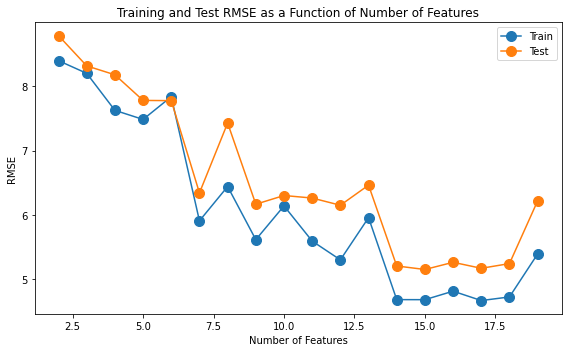

In [24]:
fig, ax = plt.subplots(1, figsize=(8, 5))
df_42=pd.DataFrame(lst).set_index('NumberFeatures')
ax.plot(df_42['RMSE_Training'], marker='.', markersize=20, label='Train')
ax.plot(df_42['RMSE_Testing'], marker='.', markersize=20, label='Test')
ax.set_xlabel('Number of Features')
ax.set_ylabel('RMSE')
ax.set_title('Training and Test RMSE as a Function of Number of Features')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

#### Observations
*As we increase the number of features, our RMSE drops in both the testing and training sets. After roughly 15 features, the decline in RMSE slows substantially, and there is a growing "wedge" between the training RSME and test RMSE, where the training RMSE continues to drop but the test RMSE nearly plateaus. In many real-world scenarios, the test RMSE will even increase as we progressively overfit the training data. In this case, we do not have enough features to observe this type of dangerous overfitting.*

### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model from 4.2 above on your training data, using the value lambda = 0.5.  Report the RMSE obtained for your training data, and the RMSE obtained for your testing data.

In [25]:
def multivariate_regularized_ols(xvalue_matrix, y, R=0.01, MaxIterations=1000, lbd=1):
    # initialize the parameters
    start_time = time.time()
    n = xvalue_matrix.shape[0]                                      
    features = xvalue_matrix.shape[1]                               
    iter = 0
    epsilon = 0.00001                                               
    beta_array = np.random.random(features)    
    
    convergence=False
    for i in range(MaxIterations):
        iter += 1
        g_b=np.dot(xvalue_matrix.T,np.dot(xvalue_matrix,beta_array)-y )+np.dot(lbd,beta_array)
        beta_array = beta_array - R/n *g_b 
        # Stopping condition based on parameters learned
        if (abs(g_b) <= epsilon).all():
            convergence=True
            ttaken=str(round(time.time() - start_time,2)) 
            return  beta_array,ttaken,iter,convergence

    ttaken=str(round(time.time() - start_time,2)) 
    return beta_array,ttaken,iter,convergence

In [26]:
def f(x,betas):
    return np.dot(x,betas)

In [27]:
# use PolynomialFeatures function to generate interaction terms
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=False)

n = len(bdata.data)
rand_order = np.arange(0,n)
np.random.shuffle(rand_order)

bdata_train = bdata.data[rand_order[:int(n*.66)],:]
bdata_train_tar = bdata.target[rand_order[:int(n*.66)]]
bdata_test = bdata.data[rand_order[int(n*.66):],:]
bdata_test_tar = bdata.target[rand_order[int(n*.66):]]

x_train = standardize(bdata_train[:,0:13])
x_train = poly.fit_transform(x_train)
x_train = np.c_[np.ones(x_train.shape[0]),x_train]
x_train_tar = bdata_train_tar[:]

x_test = standardize(bdata_test[:,0:13])
x_test = poly.fit_transform(x_test)
x_test = np.c_[np.ones(x_test.shape[0]),x_test]
x_test_tar = bdata_test_tar[:]

beta_array = np.ones(x_train.shape[1])    

R = 0.01
lbd = 0.1
beta, timetaken, iterations, convergence = multivariate_regularized_ols(x_train, x_train_tar, R, 1000000,lbd)
print("lambda={}, R={}, timetaken={}, iterations={}, converegence={}".format(lbd,R,
      timetaken,iterations,convergence))
yhat_train = f(x_train,beta)
yhat_test = f(x_test,beta)
rmse_train = np.sqrt(mean_squared_error(yhat_train,x_train_tar))
rmse_test = np.sqrt(mean_squared_error(yhat_test,x_test_tar))
print("RMSE of training set: {:.2f}".format(rmse_train))
print("RMSE of testing set: {:.2f}\n".format(rmse_test))

lbd = 0.5
beta, timetaken, iterations, convergence = multivariate_regularized_ols(x_train, x_train_tar, R, 1000000,lbd)
print("lambda={}, R={}, timetaken={}, iterations={}, converegence={}".format(lbd, R,
      timetaken,iterations,convergence))
yhat_train = f(x_train,beta)
yhat_test = f(x_test,beta)
rmse_train = np.sqrt(mean_squared_error(yhat_train,x_train_tar))
rmse_test = np.sqrt(mean_squared_error(yhat_test,x_test_tar))
print("RMSE of training set: {:.2f}".format(rmse_train))
print("RMSE of testing set: {:.2f}\n".format(rmse_test))

lbd = 1
beta, timetaken, iterations, convergence = multivariate_regularized_ols(x_train, x_train_tar, R, 1000000,lbd)
print("lambda={}, R={}, timetaken={}, iterations={}, converegence={}".format(lbd,R,
      timetaken,iterations,convergence))
yhat_train = f(x_train,beta)
yhat_test = f(x_test,beta)
rmse_train = np.sqrt(mean_squared_error(yhat_train,x_train_tar))
rmse_test = np.sqrt(mean_squared_error(yhat_test,x_test_tar))
print("RMSE of training set: {:.2f}".format(rmse_train))
print("RMSE of testing set: {:.2f}\n".format(rmse_test))

lambda=0.1, R=0.01, timetaken=51.36, iterations=1000000, converegence=False
RMSE of training set: 2.15
RMSE of testing set: 4.46

lambda=0.5, R=0.01, timetaken=46.36, iterations=698637, converegence=True
RMSE of training set: 2.18
RMSE of testing set: 4.34

lambda=1, R=0.01, timetaken=17.86, iterations=381445, converegence=True
RMSE of training set: 2.21
RMSE of testing set: 4.28



#### Observations
*With ridge regularization, we see only a very modest decrease in RMSE relative to the unregularized version. However, this is partly because we do not know that what should be the best value of lambda for regularization, and we are not using that many features in our model. As we increase lambda we observe decreasing RMSE in the test set.*

### 4.4: Cross-validate lambda


This is where it all comes together! Use k-fold cross-validation to select the optimal value of lambda. In other words, define a set of different values of lambda. Then, using the 80% of your data that you set aside for training, iterate through the values of lambda one at a time. For each value of lambda, use k-fold cross-validation to compute the average cross-validated (test) RMSE for that lambda value, computed as the average across the held-out folds. You should also record the average cross-validated train RMSE, computed as the average across the folds used for training. Create a scatter plot that shows RMSE as a function of lambda. The scatter plot should have two lines: a red line showing the cross-validated (test) RMSE, and a blue line showing the cross-validated train RMSE.  At this point, you should not have touched your held-out 20% of "true" test data.

What value of lambda minimizes your cross-validated (test) RMSE? Fix that value of lambda, and train a new model using all of your training data with that value of lambda (i.e., use the entire 80% of the data that you set aside in 4.1). Calcuate the RMSE for this model on the 20% of "true" test data. How does your test RMSE compare to the RMSE from 4.3, 4.2, 2.3, and to the RMSE from nearest neighbors? What do you make of these results?

Go brag to your friends about how you just implemented cross-validated ridge-regularized multivariate regression using gradient descent optimization, from scratch. If you still have friends.

In [28]:
# Define a grid of different labmda values
lambdas = list(np.linspace(0.1, 1, num=20))+list(np.linspace(2, 10, num=9))+list(np.linspace(15, 100, num=18))
lambdas.insert(0,0)

In [29]:
# use PolynomialFeatures function to generate interaction terms
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=False)

# CV function 
def k_fold(ds, k):
    r = []
    size_all = len(ds)
    size = int(size_all / k)
    ds_index = list(range(size_all))
    for i in range(k-1):
        np.random.seed(seed=i)
        rows = np.random.choice(ds_index, size, replace=False)
        r.append(rows.tolist())
        ds_index = list(set(ds_index) - set(rows))
    r.append(ds_index)
    return r

dict_lbd_rmse_train = {}
dict_lbd_rmse_test = {}

#train data
bdata_train = bdata.data[rand_order[:int(n*.80)],:]
bdata_train_tar = bdata.target[rand_order[:int(n*.80)]]
        
#test data
bdata_test = bdata.data[rand_order[int(n*.80):],:]
bdata_test_tar = bdata.target[rand_order[int(n*.80):]]



for lbd in lambdas:
    counter = 0
    rmse_train_sum= 0
    rmse_test_sum = 0
    size_all = len(bdata_train)
    ds_fold = k_fold(bdata_train, 5)
    ds_index = list(range(size_all))

    for i in range(5):

        val_idx = ds_fold[i]
        train_idx = list(set(ds_index) - set(val_idx))

        x_train = standardize(bdata_train[train_idx,0:13])
        x_train = poly.fit_transform(x_train)
        x_train = np.c_[np.ones(x_train.shape[0]),x_train]
        x_train_tar = bdata_train_tar[train_idx]

        val_x = standardize(bdata_train[val_idx,0:13])
        val_x = poly.fit_transform(val_x)
        val_x = np.c_[np.ones(val_x.shape[0]),val_x]
        val_y = bdata_train_tar[val_idx]

        R = 0.01
        beta, timetaken, iterations, convergence = multivariate_regularized_ols(x_train, x_train_tar, R, 100000,lbd)
        a,b1,b2 = beta[0],beta[1],beta[2]

        yhat = f(x_train,beta)

        rmse_train = np.sqrt(mean_squared_error(yhat,x_train_tar))
        rmse_train_sum += rmse_train

        yhat = f(val_x,beta)
        rmse_test = np.sqrt(mean_squared_error(yhat,val_y))
        rmse_test_sum += rmse_test
        counter += 1.0

    dict_lbd_rmse_train[lbd] = rmse_train_sum / counter
    dict_lbd_rmse_test[lbd] = rmse_test_sum / counter

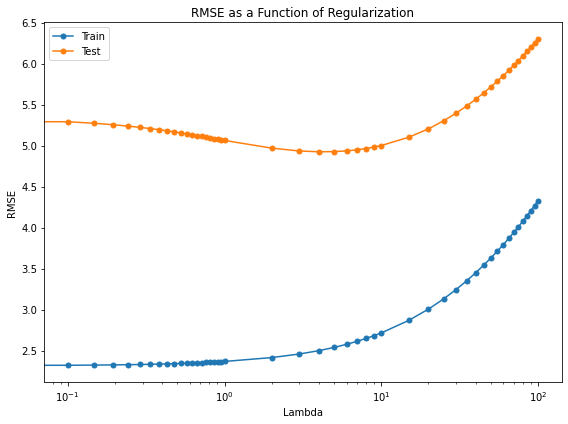

In [30]:
# Turn results into a dataframe
rmse_train_df=pd.DataFrame.from_dict(dict_lbd_rmse_train,orient='index').sort_index().reset_index()
rmse_test_df=pd.DataFrame.from_dict(dict_lbd_rmse_test,orient='index').sort_index().reset_index()
rmse_train_df.columns=['lambda','rmse_train']
rmse_test_df.columns=['lambda','rmse_validation']
merged_rmse=pd.merge(rmse_train_df,rmse_test_df,on='lambda').set_index('lambda')

# Figure
fig, ax = plt.subplots(1, figsize=(8, 6))
merged_rmse['rmse_train'].plot(ax=ax, marker='.', markersize=10, label='Train')
merged_rmse['rmse_validation'].plot(ax=ax, marker='.', markersize=10, label='Test')
ax.set_xscale('log')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_xlabel('Lambda')
ax.set_ylabel('RMSE')
ax.set_title('RMSE as a Function of Regularization')
plt.tight_layout()
plt.legend(loc='best')
plt.show()


In [31]:
# Get the optimal value of lambda -- the one associated with the lowest RMSE
merged_rmse.reset_index(inplace=True)
merged_rmse.sort_values('rmse_validation').head()

,lambda,rmse_train,rmse_validation
23,4.0,2.498309,4.924811
24,5.0,2.537625,4.926876
22,3.0,2.457205,4.934909
25,6.0,2.575430,4.935816
26,7.0,2.611911,4.948959


In [32]:
# Fit the model using the best value of lambda, get predictions on the test set
x_train = standardize(bdata_train[:,0:13])
x_train = poly.fit_transform(x_train)
x_train = np.c_[np.ones(x_train.shape[0]),x_train]
x_train_tar = bdata_train_tar

x_test = standardize(bdata_test[: ,0:13])
x_test = poly.fit_transform(x_test)
x_test = np.c_[np.ones(x_test.shape[0]),x_test]
x_test_tar = bdata_test_tar

beta, timetaken, iterations, convergence = multivariate_regularized_ols(x_train, x_train_tar, R, 1000000, lbd = 3)
print("lambda={}, R={}, timetaken={}, iterations={}, converegence={}".format(lbd, R,timetaken,iterations,convergence))
yhat_test = f(x_test, beta)
rmse_test = np.sqrt(mean_squared_error(yhat_test,x_test_tar))
print("RMSE of testing set: {:.2f}\n".format(rmse_test))




lambda=100.0, R=0.01, timetaken=7.54, iterations=161043, converegence=True
RMSE of testing set: 3.81



#### Observations
*After selecting the optimal value of lambda using cross validation, we  observe that the RMSE is slightly lower than the RMSE reported in 4.1, 4.2 and 4.3.*

###  Extra Credit 3: AdaGrad

AdaGrad is a method to implement gradient descent with different learning rates for each feature. Adaptive algorithms like this one are being extensively used especially in deep learning applications. Implement AdaGrad on 2.3 but now use CRIM, RM and DIS as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm.

In [33]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. 
    
Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""

def AdaGrad_ols(xvalue_matrix, yvalues, R=0.00001, MaxIterations=10000):
    start_time = time.time()
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)[:, np.newaxis]
    n, variable_n = xvalue_matrix.shape # sample number, varaibels number
    # initialize parameters
    params = np.random.randn(variable_n + 1, 1)
    cost = np.inf
    epsilon = 0.00001
    G = np.zeros((variable_n + 1, variable_n + 1))
    for i in range(MaxIterations):
        g = np.zeros((variable_n + 1, 1))
        cost_old = cost
        part_1 = params[0] + np.dot(xvalue_matrix, params[1:variable_n + 1]) - yvalues
        # populate gradient vector
        g[0] = part_1.sum()
        g[1:variable_n + 1] = np.dot(xvalue_matrix.T, part_1)
        # store outer product of past values of gradients 
        G += np.outer(g, g)
        # update parameters (gd steps)
        for j in range(variable_n + 1):
            params[j] -= R / n * g[j]/np.sqrt(np.diag(G)[j])
        part_2 = params[0] + np.dot(xvalue_matrix, params[1:variable_n + 1]) - yvalues
        #print(params[2])
        cost = 1.0 / (2 * n) * ((part_2 ** 2).sum())
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return params

In [34]:
df_cp = df.copy()
df_norm = standardize(df_cp)
#IPython.embed()
df_norm['MEDV'] = df['MEDV']
print('Test 1')
print(AdaGrad_ols(df_norm[['RM', 'CRIM', 'DIS']], df_norm['MEDV'], 100.5, 10000))


Test 1
Time taken: 1.15 seconds
[[21.93035383]
 [ 5.77630339]
 [-2.12722638]
 [ 0.32919241]]


In [35]:
regr_4 = LinearRegression()
regr_4.fit(df_norm[['RM', 'CRIM','DIS']], df_norm['MEDV'])
print('Intercept: {:.2f}'.format(regr_4.intercept_))
print('Coefficient of RM: {:.2f}'.format(regr_4.coef_[0]))
print('Coefficient of CRIM: {:.2f}'.format(regr_4.coef_[1]))
print('Coefficient of DIS: {:.2f}'.format(regr_4.coef_[2]))

Intercept: 22.53
Coefficient of RM: 5.78
Coefficient of CRIM: -2.13
Coefficient of DIS: 0.33
